In [86]:
%config InlineBackend.figure_format='retina'

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy import stats
from scipy.stats import pearsonr, sem
from itertools import combinations

def fisherz(r, eps=1e-5):
    return np.arctanh(r-eps)

def fisherz_inv(z):
    return np.tanh(z)
    
def simulate_ground_truth_uniform(num_items=160, min_val=1/16, max_val=1.00, 
                                  seed=1234):
    rng = np.random.default_rng(seed=seed)
    ground_truth = rng.uniform(min_val, max_val, num_items)

    return ground_truth

def simulate_ground_truth_skewed(num_items=160, alpha = 2, beta = .55, 
                                 min_val=1/16, max_val=1.0,
                                 seed=1234):
    '''
        # Increase alpha for stronger skew towards 1
        # Keeps the distribution skewed towards 1
    '''
    rng = np.random.default_rng(seed=seed)

    # Generate Beta distribution data
    beta_samples = rng.beta(alpha, beta, size=num_items)
    
    # Transform to the range [1/16, 1.0]
    skewed_ground_truth = min_val + (max_val - min_val) * beta_samples

    return skewed_ground_truth

def simulate_trials(n_subjects, ground_truth_item_acc, seed=1234):
    '''
        simulate data for n_subjects
        data will only deviate from ground_truth due to sampling error

        e.g., 
            toss a fair coin once, you can't get 50% heads!
            toss a fair coin 10 times, distribution of heads will vary on any given draw (sampling err)        
    '''
    rng = np.random.default_rng(seed=seed)
    
    n_items = len(ground_truth_item_acc)
    
    # Generate a set of 1s and 0s for each subject
    simulated_responses = rng.binomial(n=1, p=ground_truth_item_acc, size=(n_subjects, n_items))

    return simulated_responses
    
def get_split_halves(N):
    '''get all possible, unique splits of N subjects into two groups'''
    subjects = list(range(0,N))
    splits = []
    for subsetA in tqdm(combinations(subjects, N//2)):
        subsetA = list(subsetA)
        subsetB = list(np.setdiff1d(subjects, subsetA))
        assert len(np.setdiff1d(subsetA,subsetB)) == len(subsetA), "oops"
        assert len(np.setdiff1d(subsetB,subsetA)) == len(subsetB), "oops"
        assert (len(subsetA) + len(subsetB)) == N, f"oops, total should be {N}"
        splits.append((subsetA,subsetB))
    
    return splits[0:len(splits)//2] if N%2==0 else splits

def get_splits(N, num_splits=1000, seed=12345):
    rng = np.random.default_rng(seed=seed)
    splits = []
    for _ in tqdm(range(num_splits)):
        # Shuffle indices and split into two groups
        shuffled_indices = rng.permutation(N)
        half = N // 2
        
        # Split into two groups: if N is odd, the second group will have one more element
        group1 = shuffled_indices[:half]
        group2 = shuffled_indices[half:]
        
        splits.append((group1.tolist(), group2.tolist()))

    return splits

def compute_simulated_split_halves(simulated_data, num_splits=1000, seed=12345):
    N = simulated_data.shape[0]
    splits = get_splits(N, num_splits=num_splits, seed=seed)
    corrs = []
    adjusted_corrs = []
    for idxA,idxB in tqdm(splits):
        # compute average acurracy for each half of subjects
        pc_half1 = simulated_data[idxA,:].mean(axis=0)
        pc_half2 = simulated_data[idxB,:].mean(axis=0)

        # compute correlation and adjusted correlation
        corr = pearsonr(pc_half1, pc_half2)[0]
        adjusted_corr = (2 * corr) / (1 + corr)
            
        corrs.append(corr)
        adjusted_corrs.append(adjusted_corr)
    
    corrs = np.array(corrs)
    adjusted_corrs = np.array(adjusted_corrs)
    avg_adj_correlation = np.mean(adjusted_corrs)
    sem_adj_correlation = sem(adjusted_corrs)

    return avg_adj_correlation


In [8]:
n_subjects = np.arange(5,76,5)
est_dmc = []
act_dmc = []
for n_subj in n_subjects:
    ground_truth_item_acc = simulate_ground_truth_uniform(num_items=160)
    simulated_data = simulate_trials(n_subjects=n_subj, ground_truth_item_acc=ground_truth_item_acc, seed=1234)
    avg_adj_correlation = compute_simulated_split_halves(simulated_data, num_splits=1000, seed=12345)
    corr_with_ground_truth = pearsonr(simulated_data.mean(axis=0), ground_truth_item_acc)[0]

    est_dmc.append(avg_adj_correlation)
    act_dmc.append(corr_with_ground_truth)

100%|██████████| 1000/1000 [00:00<00:00, 1272.61it/s]


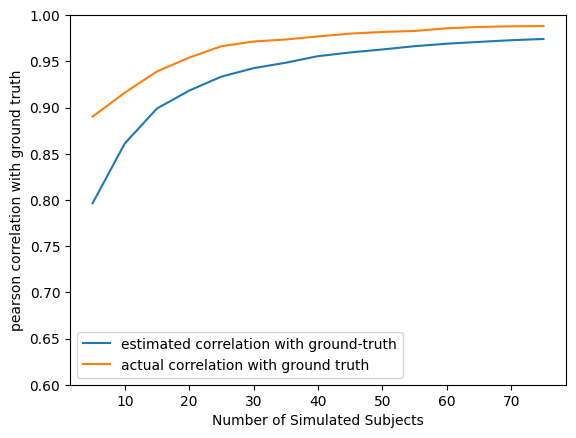

In [9]:
ax = sns.lineplot(x=n_subjects, y=est_dmc, label="estimated correlation with ground-truth")
ax = sns.lineplot(x=n_subjects, y=act_dmc, ax=ax, label="actual correlation with ground truth")
ax.set_ylim([.60, 1])
ax.set_ylabel('pearson correlation with ground truth');
ax.set_xlabel('Number of Simulated Subjects');

In [10]:
n_subjects = np.arange(5,76,5)
est_dmc = []
act_dmc = []
for n_subj in n_subjects:
    ground_truth_item_acc = simulate_ground_truth_skewed(num_items=160)
    simulated_data = simulate_trials(n_subjects=n_subj, ground_truth_item_acc=ground_truth_item_acc, seed=1234)
    avg_adj_correlation = compute_simulated_split_halves(simulated_data, num_splits=1000, seed=12345)
    corr_with_ground_truth = pearsonr(simulated_data.mean(axis=0), ground_truth_item_acc)[0]

    est_dmc.append(avg_adj_correlation)
    act_dmc.append(corr_with_ground_truth)

100%|██████████| 1000/1000 [00:00<00:00, 1863.14it/s]


In [3]:
# sns.histplot(ground_truth_item_acc)

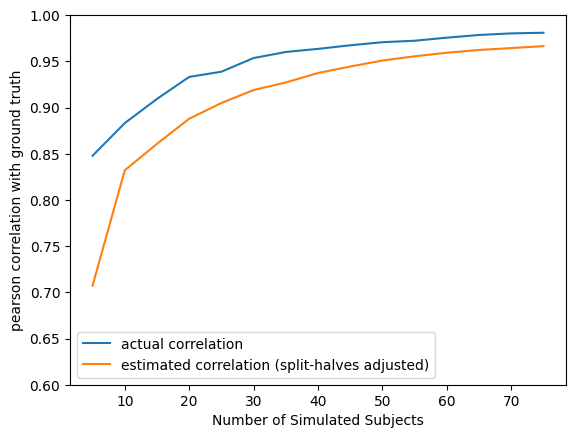

In [11]:
ax = None
ax = sns.lineplot(x=n_subjects, y=act_dmc, ax=ax, label="actual correlation")
ax = sns.lineplot(x=n_subjects, y=est_dmc, ax=ax, label="estimated correlation (split-halves adjusted)")
ax.set_ylim([.60, 1])
ax.set_ylabel('pearson correlation with ground truth');
ax.set_xlabel('Number of Simulated Subjects');

In [79]:
# ground_truth = np.uniform
rng = np.random.default_rng(seed=1234)
num_items = 160
ground_truth = rng.uniform(0, 1, num_items)
ground_truth

array([0.97669977, 0.38019574, 0.92324623, 0.26169242, 0.31909706,
       0.11809123, 0.24176629, 0.31853393, 0.96407925, 0.2636498 ,
       0.44100612, 0.60987081, 0.8636213 , 0.86375767, 0.67488131,
       0.65987435, 0.7357577 , 0.22275366, 0.17206618, 0.87041497,
       0.06013866, 0.68368891, 0.67123802, 0.61101798, 0.06013731,
       0.97776927, 0.43895163, 0.53259502, 0.00313229, 0.25126711,
       0.85849044, 0.42529835, 0.73581899, 0.92204322, 0.15347417,
       0.99225923, 0.18233178, 0.9401129 , 0.08688306, 0.46821072,
       0.8289892 , 0.28105226, 0.86909151, 0.97641657, 0.84171366,
       0.4488736 , 0.37050843, 0.48266944, 0.09218155, 0.22668311,
       0.53656624, 0.73323165, 0.44891079, 0.30550077, 0.9473596 ,
       0.75103384, 0.47204846, 0.45727588, 0.7463378 , 0.85539988,
       0.29350156, 0.7333145 , 0.8088307 , 0.88708697, 0.02483321,
       0.51254945, 0.61278568, 0.28034895, 0.45213173, 0.53122109,
       0.98863456, 0.00597817, 0.20128829, 0.2568758 , 0.34074

In [102]:
n_subjects = 23
simulated_item_accuracy_group1 = []
simulated_item_accuracy_group2 = []
for p_correct in ground_truth:
    simulated_correct_trials1 = rng.binomial(n=n_subjects, p=p_correct)
    simulated_item_accuracy_group1.append(simulated_correct_trials1/n_trials)

    simulated_correct_trials2 = rng.binomial(n=n_subjects, p=p_correct)
    simulated_item_accuracy_group2.append(simulated_correct_trials2/n_trials)
    
corr_ground_truth_vs_sample = pearsonr(simulated_item_accuracy_group1, 
                                       simulated_item_accuracy_group2)[0]

print(f"groups of {n_subjects} r={corr_ground_truth_vs_sample:3.3f}")


groups of 23 r=0.911


Generated Mean: 0.7986312308689175


<Axes: ylabel='Count'>

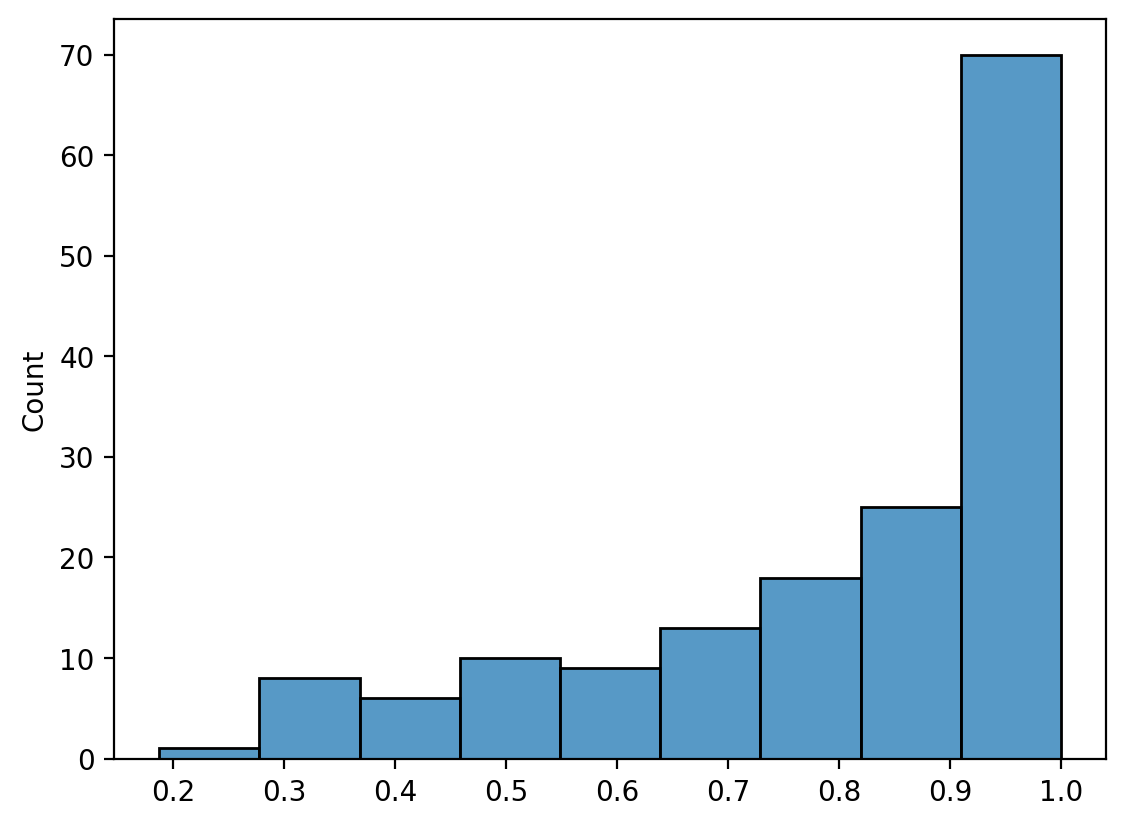

In [87]:
rng = np.random.default_rng(seed=1234)

# Parameters for the Beta distribution
alpha = 2   # Increase alpha for stronger skew towards 1
beta = .55   # Keeps the distribution skewed towards 1

# Generate Beta distribution data
n_samples = 160
beta_samples = rng.beta(alpha, beta, size=n_samples)

# Transform to the range [1/16, 1.0]
min_val, max_val = 1/16, 1.0
skewed_data = min_val + (max_val - min_val) * beta_samples

# Check the mean and ensure it's around 0.80
print("Generated Mean:", np.mean(skewed_data))
sns.histplot(skewed_data)

In [103]:
ground_truth = skewed_data
ground_truth.shape

(160,)

In [104]:
n_trials = 30
simulated_item_accuracy_group1 = []
simulated_item_accuracy_group2 = []
for p_correct in ground_truth:
    simulated_correct_trials1 = rng.binomial(n=n_trials, p=p_correct)
    simulated_item_accuracy_group1.append(simulated_correct_trials1/n_trials)

    simulated_correct_trials2 = rng.binomial(n=n_trials, p=p_correct)
    simulated_item_accuracy_group2.append(simulated_correct_trials2/n_trials)
    
corr_ground_truth_vs_sample = pearsonr(simulated_item_accuracy_group1, 
                                       simulated_item_accuracy_group2)[0]
corr_ground_truth_vs_sample

0.9138456248421951